In [0]:
# API (for RS3 - bytt ut rs med oldschool i URL): https://runescape.fandom.com/wiki/Application_programming_interface
# Eksempel på bruk - API: https://www.reddit.com/r/2007scape/comments/3g06rq/guide_using_the_old_school_ge_page_api/
# IDs++: https://rsbuddy.com/exchange/summary.json
# (IDs: https://pastebin.com/LhxJ7GRG)

In [0]:
# ------------------------------------------GE-API------------------------------------------
# Category 
# Returns number of items determined by the first letter (OSRS does only have one category/no categorie - made for RS3 (Runescape 3)) 
# http://services.runescape.com/m=itemdb_oldschool/api/catalogue/category.json?category=1

# Items 
# Returns the first 12 items in the category given determined by the first letter X (number -> X = %23)
# http://services.runescape.com/m=itemdb_oldschool/api/catalogue/items.json?category=1&alpha=X&page=1

# Detail 
# Returns current price and price trends information on tradeable items in the Grand Exchange
# ID/X -> 451 = Runite ore, 554 = Fire rune, ...
# http://services.runescape.com/m=itemdb_oldschool/api/catalogue/detail.json?item=X

# Graph 
# Shows the prices each day of a given item for the previous 180 days. The timecode is the number of milliseconds that has passed since 1 January 1970 and the price is the market value of the item for the given day.
# http://services.runescape.com/m=itemdb_oldschool/api/graph/X.json 

# -------------------------------------------OSRSbox-------------------------------------------
# Item info API
# https://github.com/osrsbox/osrsbox-api/
# https://www.osrsbox.com/projects/osrsbox-db/

# ------------------------------------------Web Scrape------------------------------------------
# Results - Noe å få ut her?
# http://services.runescape.com/m=itemdb_oldschool/Cannonball/viewitem?obj=id
# https://rsbuddy.com/exchange/summary.json

# https://www.osrsbox.com/projects/osrsbox-db/
# https://github.com/osrsbox/osrsbox-api/

In [0]:
import requests
import time
import matplotlib.pyplot as plt
import numpy as np
import json
import re

# Plot size
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 8]

class Get_data():
  
  def __init__(self):
    
    self.base_url_api = "http://services.runescape.com/m=itemdb_oldschool/api/"

  def get_id(self):

    #!!!!!! Utvid - Lagre som dict hvor navn er nøkkel - kjør i init
    
    # Annen nettside
    url = "https://rsbuddy.com/exchange/summary.json"

    data = requests.get(url)
    a_json = data.json()

    #For test
    pretty_json = json.dumps(a_json, indent = 4)
    print(a_json["2"]["name"])
    print(pretty_json)   
  
  def get_price_data_from_id(self, id):

    # Generate URL
    item = self.base_url_api + "graph/" + str(id) + ".json"
    
    # Get data
    data = requests.get(item)
    a_json = data.json()

    # Temporary solution to extract price
    price = []
    for x in a_json["daily"].values():
      price.append(x)

    # Temporary solution to extract price trend
    average_price = []
    for x in a_json["average"].values():
      average_price.append(x)

    # Temporary solution to get correct date
    date = []
    for x in a_json["daily"]:
      date.append(time.strftime("%d %b", time.localtime(int(x)/1000)))

    return price, average_price, date

  def get_number_sold(self, id):

    url = "http://services.runescape.com/m=itemdb_oldschool/Cannonball/viewitem?obj=" + str(id)
    data = requests.get(url)

    # Patern for the traded data (Regex)
    pattern = re.compile(r"trade180\.push\(\[new Date\('\d{4}/\d{2}/\d{2}'\), (\d+)\]\);")
    matches = pattern.finditer(data.text)
        
    sold = []
    for match in matches:
      pos = match.group(1)
      sold.append(int(pos))

    return sold

  def get_info_form_id(self, id):
    
    # Generate URL
    item_info = self.base_url_api + "catalogue/detail.json?item=" + str(id)

    data = requests.get(item_info)
    item_info_json = data.json()

    return item_info_json
  
  def plot_price(self, date, price, average_price = 0, item_name = "none", start = 0, stop = 179, min_max_on = True):
    
    if(min_max_on):
      max_price = np.full(stop, max(price[start:stop]))
      min_price = np.full(stop, min(price[start:stop]))
      plt.plot(date[start:stop], max_price, '.', label = "Max - " + "{:,}".format(max(price[start:stop])))
      plt.plot(date[start:stop], min_price, '.', label = "Min - " + "{:,}".format(min(price[start:stop])))

    if(average_price != 0):
      plt.plot(date[start:stop], average_price[start:stop], label = "Trend")

    plt.plot(date[start:stop], price[start:stop], label = "Price")
    plt.xlabel("Date", fontsize=15)
    plt.ylabel("Price (GP)", fontsize=15)
    plt.title(item_name, fontsize=25, color="w")
    plt.legend(loc = 2)
    # Space between dates
    plt.xticks(np.arange(start, stop, step=7))

    plt.show()
  
  def bar_plot(self, date, sold, item_name = "none", start = 0, stop = 179, max_on = True, average_on = True):
    
    if(max_on):
      max_sold = np.full(stop, max(sold[start:stop]))
      plt.plot(date[start:stop], max_sold, '.', label = "Max - " + "{:,}".format(max(sold[start:stop])))

    if(average_on):
      average = np.sum(sold)/(stop+1)
      average_arr = np.full(stop, average)
      plt.plot(date[start:stop], average_arr, '.', label = "Average sold - " + "{:,}".format(round(average,1))) 
    
    plt.bar(date[0:len(sold)], sold, label = "Sold")
    plt.xlabel("Date", fontsize=15)
    plt.ylabel("Number of items traded", fontsize=15)
    plt.title("Number of sold " + item_name, fontsize=25, color="w")
    plt.legend(loc = 2)
    # Space between dates
    plt.xticks(np.arange(0, 179, step=7))

    plt.show()

  def explore_with_urls(self, url):

    data = requests.get(url)
    print(data.text)
    a_json = data.json()

    #For testing
    #print(data)
    pretty_json = json.dumps(a_json, indent = 4)
    print(pretty_json)  

  def get_player_count(self):

    url = "https://oldschool.runescape.com/"

    data = requests.get(url)

    # Patern for the traded data (Regex)
    pattern = re.compile(r"<p class='player-count'>There are currently (\d*,\d*) people playing!</p>")
    player_count = pattern.finditer(data.text)

    for number in player_count:
      players_online = number.group(1)

    players_online_no_comma = players_online.replace(",", "")

    return int(players_online_no_comma)

  def get_info_from_item_name(self, item_name, members = False, tradeable = False, tradeable_GE = False, lowalch = False, highalch = False, buy_limit = False):

    # Ensure that first letter is capital
    item_name_upper = item_name.capitalize()
    # Correct format for space
    item_name_upper_space = item_name_upper.replace(" ", "%20")
    url = "https://api.osrsbox.com/items?where={\"name\":\"" + item_name_upper_space + "\"}"
    
    # Get data
    data = requests.get(url)
    a_json = data.json()

    if(members):
      return a_json["_items"][0]["members"]
    elif(tradeable):
      return a_json["_items"][0]["tradeable"]
    elif(tradeable_GE):
      return a_json["_items"][0]["tradeable_on_ge"]
    elif(lowalch):
      return a_json["_items"][0]["lowalch"]
    elif(highalch):
      return a_json["_items"][0]["highalch"]
    elif(buy_limit):
      return a_json["_items"][0]["buy_limit"]
    else:
      return a_json["_items"][0]["id"]

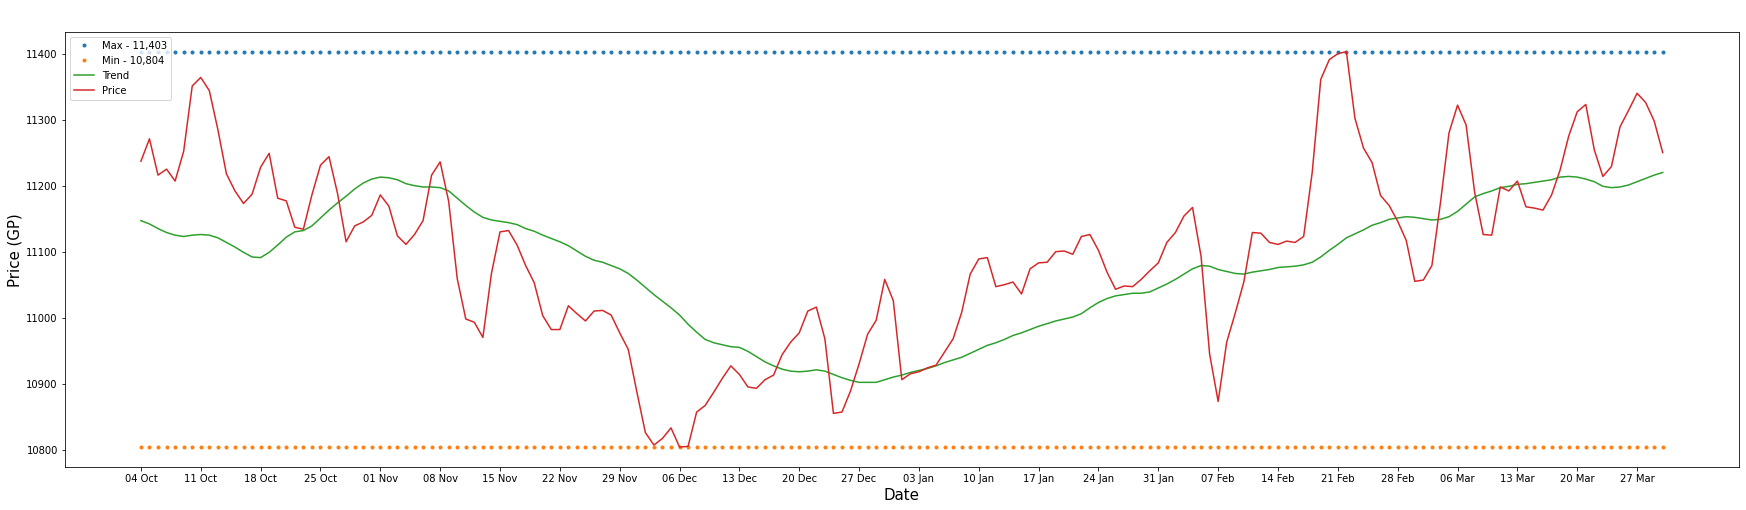

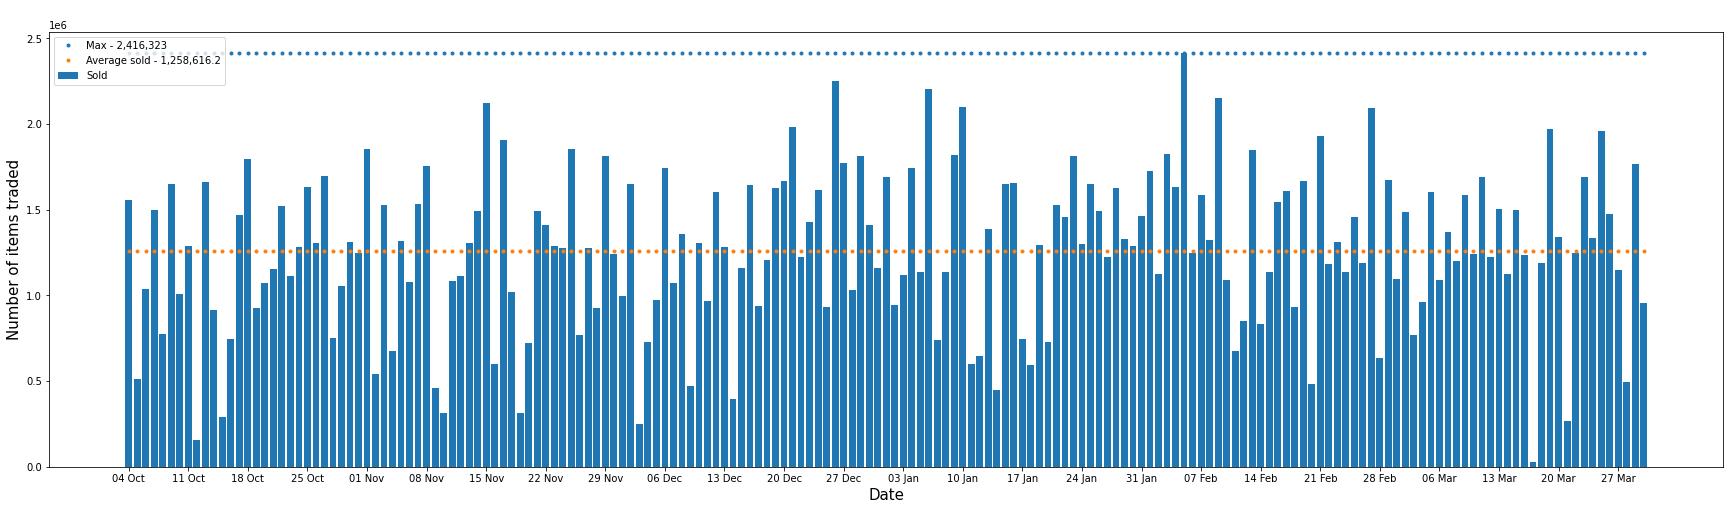

Current player count is 90,751


In [0]:
#id = 2        # Cannonball
#id = 245      # Wine of zamorak
#id = 451      # Runite ore
#id = 449      # Adamantite ore
#id = 554      # Fire rune
#id = 4151     # Abyssal whip
#id = 13190    # Bond

a = Get_data()

id = a.get_info_from_item_name("Runite ore")

price, average_price, date = a.get_price_data_from_id(id)
data = a.get_info_form_id(id)
sold = a.get_number_sold(id)

a.plot_price(date, price, average_price, data["item"]["name"])
a.bar_plot(date, sold, data["item"]["name"])

player_count = a.get_player_count()
print("Current player count is " + "{:,}".format(player_count))

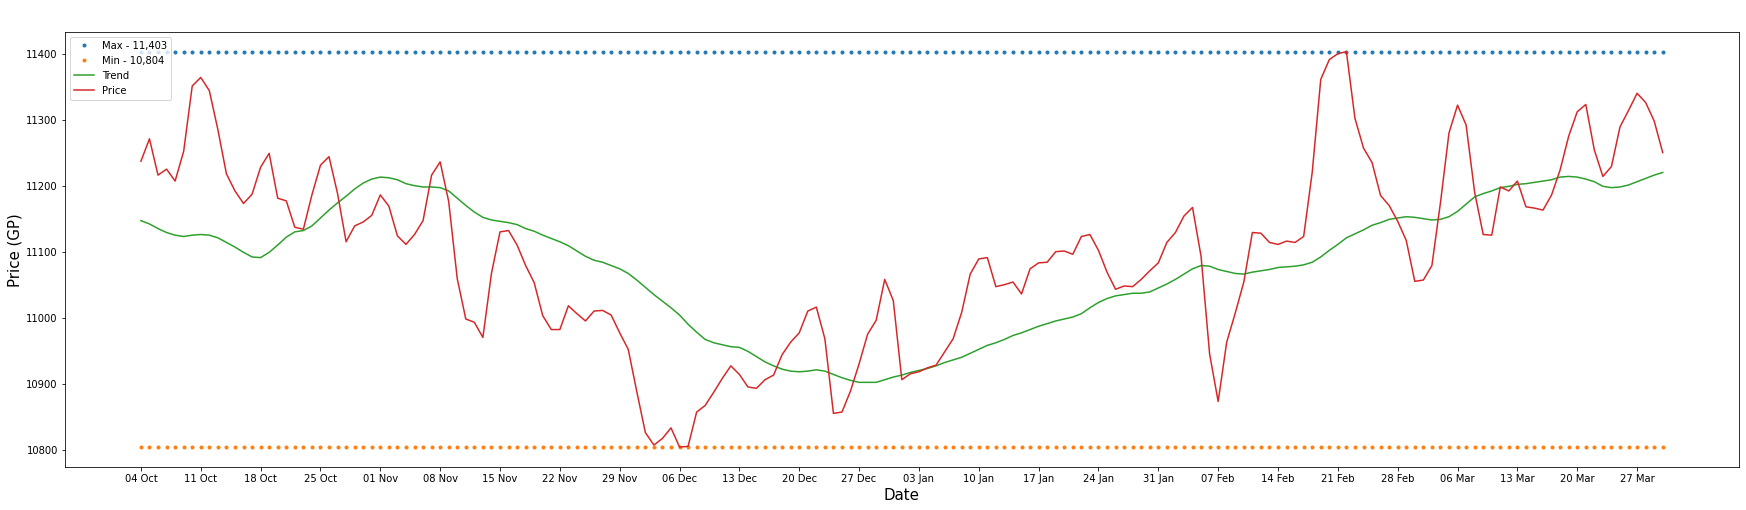

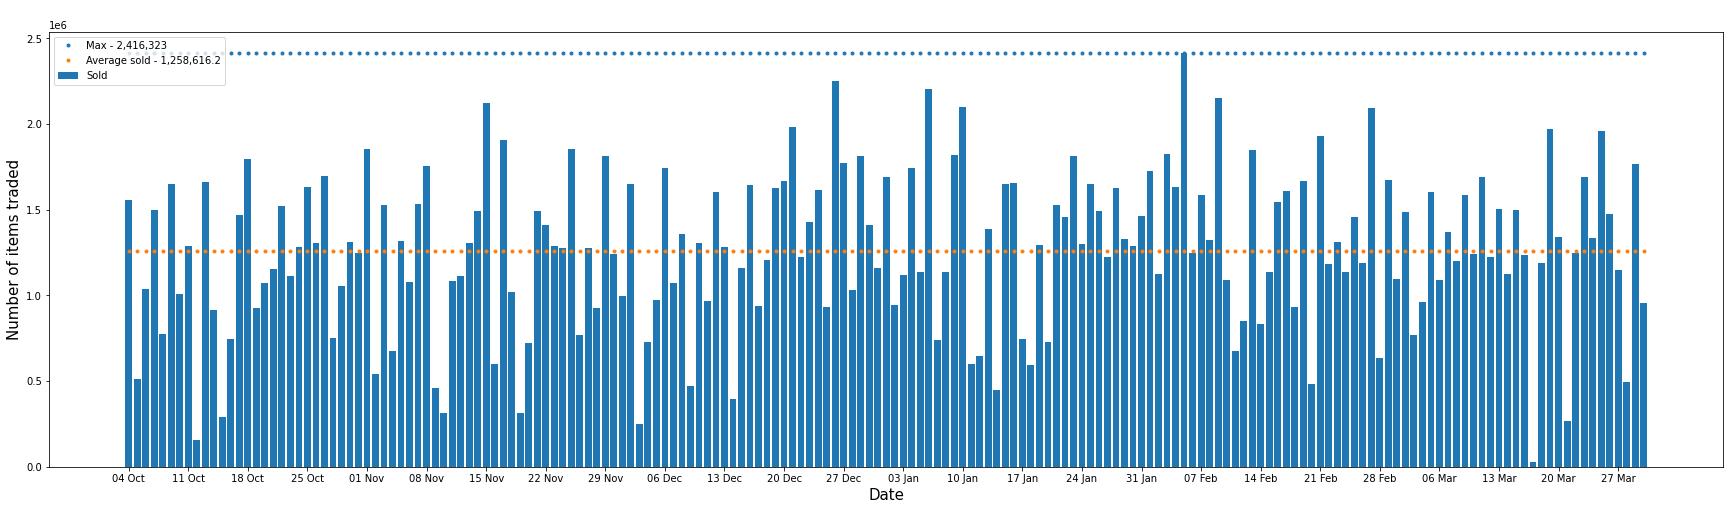

In [0]:
"""
Må legges til
* Plot uke, måned, kvartal, (halvt år)
"""

a = Get_data()

id = a.get_info_from_item_name("Runite ore")

price, average_price, date = a.get_price_data_from_id(id)
data = a.get_info_form_id(id)
sold = a.get_number_sold(id)

a.plot_price(date, price, average_price, data["item"]["name"])
a.bar_plot(date, sold, data["item"]["name"])